# 1 DataSet Construction

## 1.1 Components Data

In [6]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import yfinance as yf

### Scraping Index Components From BlackRock ETFs

In [7]:
"""
This notebook extracts Historical Data of the Stock Components of several ETF 
issued by _BlackRock_. A Long History (from 2006Q3) is Publicly Available for:
+ SP500 (IVV), 
+ SP100 (OEF), 
+ RUSSELL1000 (IWB), 
+ RUSSELL2000 (IWM), 
+ RUSSELL3000 (IWV).
_Vanguard_ site (the largest Global issuer for passive indexing) 
does not record historical data of index (ETF) components,
Moreover their corresponding ETFs were issued much later than year 2K
"""

import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import json

BLACKROCK_CL_URL_ROOT = "https://www.blackrock.com/cl/productos/"

def index_components_finder(symbol="IVV", path = "data/pkl/"):
    """Scrapes BlackRock website public component time-series data for supported financial ETF products.
    Args:
        tickers : {‘IVV’, 'OEF', ‘IWB’, ‘IWM’, ‘IWV’}, default ‘IVV’ (S&P500)
        path : str, default './data/pkl'
    """
    
    etf_url = {        
        "IVV": "239726/ishares-core-sp-500-etf", # iShares Core S&P 500 ETF
        "OEF": "239723/ishares-core-sp-100-etf", # iShares Core S&P 500 ETF
        "IWB": "239707/ishares-russell-1000-etf", # iShares Russell 1000 ETF
        "IWM": "239710/ishares-russell-2000-etf", # iShares Russell 2000 ETF
        "IWV": "239714/ishares-russell-3000-etf", # iShares Russell 3000 ETF
    }

    url = BLACKROCK_CL_URL_ROOT + etf_url[symbol] + "#tabsAll"    
    # request page
    html = requests.get(url).content
    soup = BeautifulSoup(html)

    # find available dates
    holdings = soup.find("div", {"id": "holdings"})
    dates_div = holdings.find_all("div", "component-date-list")[1]
    dates_div.find_all("option")
    dates = [option.attrs["value"] for option in dates_div.find_all("option")]

    # download constituents for each date
    constituents = pd.Series(dtype=object)
    for date in dates:
        resp = requests.get(BLACKROCK_CL_URL_ROOT
        +etf_url[symbol]
        +f"/1506433277024.ajax?tab=all&fileType=json&asOfDate={date}").content[3:]
        tickers = json.loads(resp)
        tickers = [(arr[0], arr[1]) for arr in tickers['aaData']]
        date = datetime.strptime(date, "%Y%m%d")
        constituents[date] = tickers

    constituents = constituents.iloc[::-1] # reverse into cronlogical order
    
    # for pickle filename construction and saving (serial date)
    last_date = constituents.index[-1].strftime("%Y%m%d")
    pklfile_fullpath = path + symbol + "_historical_components_" + last_date + ".pkl"    
    constituents.to_pickle(pklfile_fullpath)
    return constituents

## 1.2 **S&P100**: 10Y Survivors and Total Return Performance

In [8]:
oef = index_components_finder("OEF")

In [3]:
import time
import re

def change_ticker(ticker):
    rename_table = {
        "-": "LPRAX", # BlackRock LifePath Dynamic Retirement Fund
        "8686": "AFL", # AFLAC
        "4XS": "ESRX", # Express Scripts Holding Company 
        "AAZ": "APC", # Anadarko Petroleum Corporation
        "AG4": "AGN", # Allergan plc
        "BFB": "BF-B", # Brown-Forman Corporation
        "BF.B": "BF-B", # Brown-Forman Corporation
        "BF/B": "BF-B", # Brown-Forman Corporation
        "BF_B" : "BF-B", # Brown-Forman Corporation
        "BLD WI": "BLD", # TopBuild Corp.
        "BRKB": "BRK-B", # Berkshire Hathaway Inc.
        "BRK_B": "BRK-B", # Berkshire Hathaway Inc.
        "CC WI": "CC", # The Chemours Company
        "DC7": "DFS", # Discover Financial Services
        "DWDP": "DD", # Discover Financial Services
        "FB": "META",   # Facebook
        "GGQ7": "GOOG", # Alphabet Inc. Class C
        "GEC": "GE", # General Electric
        "HNZ": "KHC", # The Kraft Heinz Company
        "INCO": "INTC", # Intel
        "LOM": "LMT", # Lockheed Martin Corp.
        "LTD": "LB", # L Brands Inc.
        "LTR": "L", # Loews Corporation        
        "MPN": "MPC", # Marathon Petroleum Corp.
        "MYL": "VTRS", # Mylan NV (VIATRIS)
        "MWZ": "MET", # Metlife Inc.
        "MX4A": "CME", # CME Group Inc.
        "NCRA": "NWSA", # News Corporation
        "NTH": "NOC", # Northrop Grumman Crop.
        "PA9": "TRV", # The Travelers Companies, Inc.
        "QCI": "QCOM", # Qualcomm Inc.
        "RN7": "RF", # Regions Financial Corp
        "RTN" : "RTX", # Raytheon
        "SLBA": "SLB", # Schlumberger Limited
        "SYF-W": "SYF", # Synchrony Financial
        "SWG": "SCHW", # The Charles Schwab Corporation 
        "UAC/C": "UAA", # Under Armour Inc Class A
        "UBSFT": "UBSFY", # Ubisoft Entertainment
        "USX1": "X", # United States Steel Corporation
        "UUM": "UNM", # Unum Group
        "VISA": "V", # Visa Inc         
        "VIAC": "VIA", # viacom
        "WLTW": "WTW" # Willis Towers Watson                
    }
    if ticker in rename_table:
        fix = rename_table[ticker]
    else:
        fix = re.sub(r'[^A-Z]+', '', ticker)
    return fix

In [10]:
def all_times_symbols(financial_index, start_date, end_date):
    symbols = [change_ticker(elements[0]) for elements in financial_index[start_date:end_date][0]]
    all_symbols = symbols
    symbols = set(symbols)        

    for i, _ in enumerate(financial_index[start_date:end_date]):
        if i>0:
            sym = [change_ticker(stocks[0]) for stocks in financial_index[start_date:end_date][i]]        
            all_symbols.extend(sym)
            symbols = symbols.intersection(set(sym))
            
        else:
            continue
    return symbols, set(all_symbols)

In [11]:
tickers, all_tickers = all_times_symbols(oef, "2011-06-29", "2022-08-01")

In [12]:
var_symbols = all_tickers.difference(tickers)
print(var_symbols)

{'PCLN', 'OXY', 'CRM', 'AA', 'ADBE', 'AMT', 'AGN', 'ACT', 'ALL', 'XRX', 'WY', 'ABBV', 'TMO', 'ALD', 'DHR', 'XTSLA', 'FCX', 'WMB', 'KFT', 'KTF', 'EMC', 'KMI', 'KHC', 'MON', 'WBA', 'BAX', 'ESH', 'MDLZ', 'WPG', 'MSFUT', 'NVDA', 'OXYWSWI', 'AEP', 'SPG', 'ACN', 'ESZ', 'LPRAX', 'CHTR', 'CRC', 'AIG', 'UTX', 'DELL', 'FB', 'HAL', 'AVP', 'ETR', 'APA', 'HON', 'FOXA', 'SBUX', 'GOOG', 'SCHW', 'LLY', 'BLK', 'RTN', 'AXP', 'APC', 'CMCSK', 'RTX', 'META', 'ESU', 'BHI', 'HPQ', 'SLB', 'NEE', 'PYPL', 'S', 'FOX', 'BLKFDS', 'TSLA', 'GM', 'TMUS', 'BIIB', 'DUK', 'NOV', 'NWSA', 'DVN', 'WAG', 'CELG', 'CC', 'NFLX', 'USD', 'LIN', 'DOW', 'EBAY', 'TWX', 'AVGO', 'NSC', 'AEC', 'BKNG', 'ESM'}


In [13]:
len(var_symbols)

91

In [14]:
print(tickers)

{'NKE', 'WMT', 'UPS', 'TXN', 'MO', 'MMM', 'EMR', 'USB', 'CMCSA', 'COP', 'XOM', 'KO', 'AMGN', 'AAPL', 'QCOM', 'BRK-B', 'CSCO', 'CAT', 'F', 'T', 'JPM', 'UNP', 'PM', 'JNJ', 'IBM', 'DIS', 'GILD', 'PEP', 'V', 'FDX', 'PG', 'GOOGL', 'LMT', 'BMY', 'MS', 'C', 'GE', 'UNH', 'BAC', 'MDT', 'EXC', 'PFE', 'GD', 'BK', 'SO', 'BA', 'CVS', 'COF', 'DD', 'MRK', 'AMZN', 'MSFT', 'COST', 'ORCL', 'CL', 'MET', 'INTC', 'MA', 'MCD', 'HD', 'VZ', 'CVX', 'WFC', 'GS', 'ABT', 'TGT', 'LOW'}


In [15]:
data = yf.download(
    list(tickers), 
    start="2011-06-29", 
    end="2022-08-01"
)["Adj Close"]

[*********************100%***********************]  67 of 67 completed


In [16]:
data.head()

,AAPL,ABT,AMGN,AMZN,BA,BAC,BK,BMY,BRK-B,C,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-28,10.223415,19.818769,44.267136,10.1175,58.219566,9.173676,19.050795,20.295321,76.419998,33.617455,...,23.876259,43.582527,39.962994,51.654606,18.416531,17.383270,21.897718,20.037477,40.663376,50.620132
2011-06-29,10.186214,19.784637,43.610485,10.2090,58.728355,9.444983,19.797880,20.489155,77.029999,34.747799,...,23.801594,43.388912,40.461872,51.604416,18.757164,19.990294,21.987539,20.460230,40.748524,51.014267
2011-06-30,10.235918,19.959114,44.040684,10.2245,59.705536,9.292374,19.937962,20.790680,77.389999,34.865036,...,24.510859,43.422581,41.011848,52.285511,18.890461,19.456875,22.292921,20.452940,41.135574,51.732616
2011-07-01,10.467370,20.141180,43.987862,10.4745,59.980156,9.402595,20.280367,20.927078,78.089996,35.903282,...,25.026018,44.727444,41.938938,53.023937,19.297737,20.313572,22.634222,20.897573,41.422001,52.133080
2011-07-05,10.655519,20.163935,43.716137,10.6595,59.883205,9.326288,20.000216,20.934256,77.309998,35.643719,...,24.578058,44.491718,41.530384,52.894894,18.949701,20.394394,22.646204,20.715349,41.329090,51.872471


In [17]:
yfinance_exceptions = ['GAS', 'HAR', 'CSC', 'EMC', 'GME', 'POM', 'PCL', 'COV', 'ETN', 'COL', 'LLL']

In [18]:
set(data.columns).intersection(yfinance_exceptions)

set()

In [19]:
oef_daily_rets = data.pct_change()
oef_daily_rets

,AAPL,ABT,AMGN,AMZN,BA,BAC,BK,BMY,BRK-B,C,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-29,-0.003639,-0.001722,-0.014834,0.009044,0.008739,0.029575,0.039215,0.009551,0.007982,0.033624,...,-0.003127,-0.004442,0.012484,-0.000972,0.018496,0.149973,0.004102,0.021098,0.002094,0.007786
2011-06-30,0.004879,0.008819,0.009865,0.001518,0.016639,-0.016158,0.007076,0.014716,0.004674,0.003374,...,0.029799,0.000776,0.013592,0.013198,0.007106,-0.026684,0.013889,-0.000356,0.009499,0.014081
2011-07-01,0.022612,0.009122,-0.001199,0.024451,0.004600,0.011861,0.017174,0.006561,0.009045,0.029779,...,0.021018,0.030050,0.022605,0.014123,0.021560,0.044031,0.015310,0.021739,0.006963,0.007741
2011-07-05,0.017975,0.001130,-0.006177,0.017662,-0.001616,-0.008115,-0.013814,0.000343,-0.009988,-0.007230,...,-0.017900,-0.005270,-0.009742,-0.002434,-0.018035,0.003979,0.000529,-0.008720,-0.002243,-0.004999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,-0.007398,-0.006410,0.011262,-0.010456,-0.009611,0.008974,0.007022,-0.001508,0.007205,0.004816,...,-0.004271,0.015458,0.018557,-0.000372,0.007126,0.002667,0.006974,0.007644,-0.001437,0.033303
2022-07-26,-0.008826,0.005438,0.009730,-0.052254,-0.004597,-0.020160,-0.021153,0.010846,-0.009306,-0.014571,...,-0.014461,0.004004,-0.006395,-0.033952,-0.013111,-0.008307,0.003575,-0.013793,-0.076049,-0.003890
2022-07-27,0.034235,0.008250,0.002309,0.053654,0.001090,0.016339,0.018285,0.016026,0.017490,0.018482,...,0.066526,0.005681,0.018151,0.013056,0.016660,-0.009506,-0.000223,0.018881,0.037793,0.021645


In [20]:
start_date = oef_daily_rets.index[0].strftime("%Y-%m-%d")
end_date = oef_daily_rets.index[-1].strftime("%Y-%m-%d")

In [21]:
eqwl_prices = yf.download("EQWL", start=start_date, end=end_date)["Adj Close"]
eqwl_prices /= eqwl_prices[0]

[*********************100%***********************]  1 of 1 completed


In [22]:
surv_eqwl_daily_rets = oef_daily_rets
surv_eqwl_daily_rets

,AAPL,ABT,AMGN,AMZN,BA,BAC,BK,BMY,BRK-B,C,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-29,-0.003639,-0.001722,-0.014834,0.009044,0.008739,0.029575,0.039215,0.009551,0.007982,0.033624,...,-0.003127,-0.004442,0.012484,-0.000972,0.018496,0.149973,0.004102,0.021098,0.002094,0.007786
2011-06-30,0.004879,0.008819,0.009865,0.001518,0.016639,-0.016158,0.007076,0.014716,0.004674,0.003374,...,0.029799,0.000776,0.013592,0.013198,0.007106,-0.026684,0.013889,-0.000356,0.009499,0.014081
2011-07-01,0.022612,0.009122,-0.001199,0.024451,0.004600,0.011861,0.017174,0.006561,0.009045,0.029779,...,0.021018,0.030050,0.022605,0.014123,0.021560,0.044031,0.015310,0.021739,0.006963,0.007741
2011-07-05,0.017975,0.001130,-0.006177,0.017662,-0.001616,-0.008115,-0.013814,0.000343,-0.009988,-0.007230,...,-0.017900,-0.005270,-0.009742,-0.002434,-0.018035,0.003979,0.000529,-0.008720,-0.002243,-0.004999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,-0.007398,-0.006410,0.011262,-0.010456,-0.009611,0.008974,0.007022,-0.001508,0.007205,0.004816,...,-0.004271,0.015458,0.018557,-0.000372,0.007126,0.002667,0.006974,0.007644,-0.001437,0.033303
2022-07-26,-0.008826,0.005438,0.009730,-0.052254,-0.004597,-0.020160,-0.021153,0.010846,-0.009306,-0.014571,...,-0.014461,0.004004,-0.006395,-0.033952,-0.013111,-0.008307,0.003575,-0.013793,-0.076049,-0.003890
2022-07-27,0.034235,0.008250,0.002309,0.053654,0.001090,0.016339,0.018285,0.016026,0.017490,0.018482,...,0.066526,0.005681,0.018151,0.013056,0.016660,-0.009506,-0.000223,0.018881,0.037793,0.021645


In [23]:
eqwl_prices

Date
2011-06-27    1.000000
2011-06-28    1.007281
2011-06-29    1.016990
2011-06-30    1.027913
2011-07-01    1.042071
                ...   
2022-07-22    3.743753
2022-07-25    3.759403
2022-07-26    3.722046
2022-07-27    3.794235
2022-07-28    3.825534
Name: Adj Close, Length: 2791, dtype: float64

<AxesSubplot:xlabel='Date'>

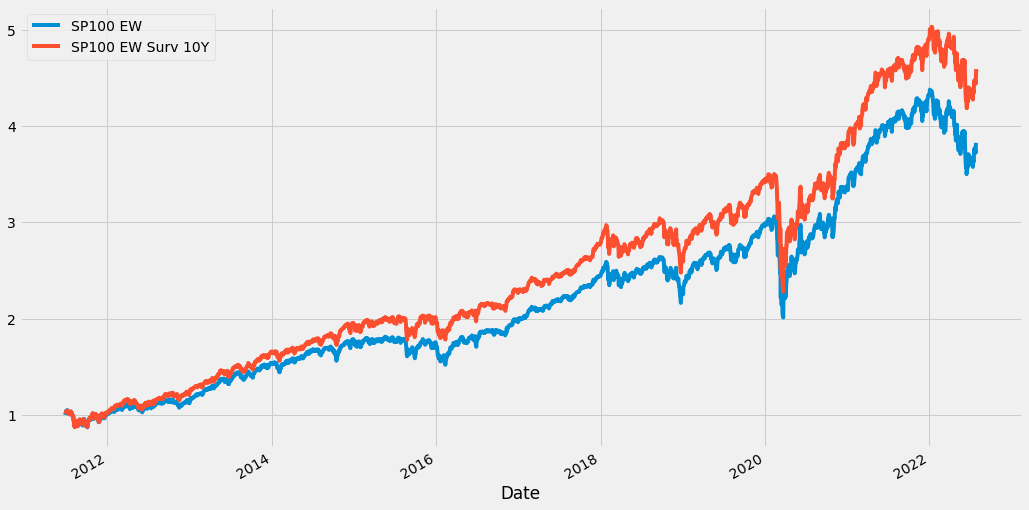

In [24]:
eqwl_prices.rename("SP100 EW").plot(figsize=(16,9), legend=True)
(1+surv_eqwl_daily_rets.mean(axis=1)).rename("SP100 EW Surv 10Y").cumprod().plot(legend=True)

In [25]:
eqwl_daily_rets = eqwl_prices.pct_change()
eqwl_daily_rets

Date
2011-06-27         NaN
2011-06-28    0.007281
2011-06-29    0.009639
2011-06-30    0.010740
2011-07-01    0.013774
                ...   
2022-07-22   -0.006298
2022-07-25    0.004180
2022-07-26   -0.009937
2022-07-27    0.019395
2022-07-28    0.008249
Name: Adj Close, Length: 2791, dtype: float64

In [26]:
surv_eqwl_total_return = (1+surv_eqwl_daily_rets.mean(axis=1)).cumprod()[-1]-1
eqwl_total_return = (1+eqwl_daily_rets+0.002/252).cumprod()[-1]-1

In [27]:
yld_surv_eqwl = 100*(surv_eqwl_total_return**.1 -1)
yld_eqwl = 100*(eqwl_total_return**.1 -1)
print(f"1Y Yield Equivalent 10Y Survivors of S&P100: {yld_surv_eqwl}%")
print(f"1Y Yield Equivalent $EQWL (SP100 EW): {yld_eqwl}%")

1Y Yield Equivalent 10Y Survivors of S&P100: 13.641571218756576%
1Y Yield Equivalent $EQWL (SP100 EW): 11.27726906355402%


In [28]:
surv_eqwl_cumreturn = (1+surv_eqwl_daily_rets.mean(axis=1)).cumprod()-1
eqwl_cumreturn = (1+eqwl_daily_rets+0.002/252).cumprod()-1

In [29]:
100*surv_eqwl_daily_rets.mean(axis=1).mean(axis=0)*252

15.297049851742893

In [30]:
100*eqwl_daily_rets.mean()*252

13.51016582548555

In [31]:
import numpy as np
100*surv_eqwl_daily_rets.mean(axis=1).std(axis=0)*np.sqrt(252)

17.430837117911544

In [32]:
100*eqwl_daily_rets.std()*np.sqrt(252)

16.624266226876898

In [33]:
SR = surv_eqwl_daily_rets.mean(axis=1).mean(axis=0)*252 / (surv_eqwl_daily_rets.mean(axis=1).std(axis=0)*np.sqrt(252))
SR0 = eqwl_daily_rets.mean()*252 / (eqwl_daily_rets.std()*np.sqrt(252))
print(SR)
print(SR0)

0.8775854967988875
0.8126774223359888


In [39]:
sp100_composition_ini = [change_ticker(sym[0]) for sym in oef[0]]
sp100_composition_fin = [change_ticker(sym[0]) for sym in oef[-1]]

In [40]:
sp100_survivalists = set(sp100_composition_ini).intersection(set(sp100_composition_fin))
len(sp100_survivalists)

48

In [41]:
sp100_after2012Q2 = oef[oef.index>"2012-06-01"]
sp100_after2012Q2

2012-06-29    [(-, BLACKROCK FDS III), (ALL, ALLSTATE CORP),...
2012-07-31    [(-, BLACKROCK FDS III), (ALL, ALLSTATE CORP),...
2012-08-31    [(-, BLACKROCK FDS III), (DELL, DELL INC.), (H...
2012-09-28    [(AAPL*, APPLE INC), (XOM, EXXON MOBIL CORP), ...
2012-10-31    [(AAPL*, APPLE INC), (XOM, EXXON MOBIL CORP), ...
                                    ...                        
2022-05-31    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-06-30    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-07-29    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-08-31    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-09-08    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
Length: 119, dtype: object

In [47]:
sp100_after2012Q2_composition = set([change_ticker(sym[0]) for sym in sp100_after2012Q2[0]])
sp100_composition_fin = set(sp100_composition_fin)

In [43]:
type(sp100_after2012Q2_composition)

set

In [48]:
sp100_10y_survivalists = sp100_after2012Q2_composition.intersection(sp100_composition_fin)

In [51]:
len(sp100_10y_survivalists)

73

### Completing the SP100 with SP500 15Y+ Survivors


In [381]:
ivv = index_components_finder("IVV") # The Market Cap Weighted SP500 ETF (BlackRock Issued)

* 15Y+ **Survivalists**:

In [385]:
composition_ini = [change_ticker(sym[0]) for sym in ivv[0]]
composition_fin = [change_ticker(sym[0]) for sym in ivv[-1]]
sp500_survivalists = set(composition_ini).intersection(set(composition_fin))
len(sp500_survivalists)

248

In [78]:
raw_returns = pd.read_csv(
    "data/config/20220814_daily_raw_returns_merged.csv", 
    index_col="Date", 
    parse_dates=True,
    na_values="#N/A"
)

In [386]:
oef

2006-09-29    [(UIS, UNISYS CORP), (RSHCQ, RS LEGACY CORP), ...
2006-10-31    [(RSHCQ, RS LEGACY CORP), (OMX, OFFICEMAX INC....
2006-11-30    [(OMX, OFFICEMAX INC.), (BDK, THE BLACK & DECK...
2006-12-29    [(BGIXX, BLK CASH FUND INST INST CLASS), (BDK,...
2007-01-31    [(BDK, THE BLACK & DECKER CORPORATION), (NSM.2...
                                    ...                        
2022-05-31    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-06-30    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-07-29    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-08-31    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
2022-09-08    [(AAPL, APPLE INC), (MSFT, MICROSOFT CORP), (A...
Length: 188, dtype: object

In [106]:
sp500_surv_prices = yf.download(
    list(sp500_survivalists), 
    ivv.index[0], 
    ivv.index[-1]
)["Adj Close"]

[*********************100%***********************]  248 of 248 completed


In [110]:
sp500_surv_prices.isna().sum().sort_values(ascending=False).head(25)

CEG     3853
DOW     3138
IR      2673
KHC     2205
HLT     1814
NWSA    1691
HCA     1119
KMI     1101
DG       788
NKE        0
NTAP       0
NSC        0
NOC        0
NI         0
NUE        0
NEM        0
NEE        0
MU         0
MSFT       0
NTRS       0
A          0
NVDA       0
NWL        0
MRO        0
OMC        0
dtype: int64

In [111]:
from modules import performance_measures_helper as pms

In [116]:
pms.net_cumreturn(sp500_surv_prices.pct_change(), last_row=True).sort_values(ascending=False).head(52)

AMZN     80.331655
AAPL     65.412818
NVDA     29.312903
AZO      20.087053
SHW      14.784241
COST     13.807715
EL       13.710640
INTU     13.681736
TMO      13.624752
UNP      13.406811
KLAC     12.674769
CTAS     12.216009
MSFT     12.012860
NEE      11.782890
UNH      11.756628
HD       11.165947
NKE      11.012426
DE       10.908181
CSX      10.730843
DG       10.698479
TJX      10.345748
NOC      10.341632
DHR      10.319440
GWW      10.287544
GOOGL     9.837063
MCD       9.496241
VRSN      9.480269
AON       9.235965
CMI       9.171822
ADBE      8.906600
ADP       8.508120
STZ       8.482107
LLY       8.252102
LOW       8.216111
HCA       7.915167
PGR       7.913637
FISV      7.869784
MMC       7.565162
ABC       7.425996
AMP       7.375102
YUM       7.307929
NSC       7.097216
HUM       7.021534
PKI       7.017957
CMS       6.943051
LMT       6.906942
MCK       6.892651
CI        6.775979
ADI       6.594815
WM        6.367221
SNA       6.274029
DTE       6.160004
Name: 2022-0

In [117]:
sp100_suplement = set(sp500_survivalists).difference(set(sp100_survivalists))
print(sp100_suplement)

{'CMA', 'NKE', 'EFX', 'OXY', 'ETN', 'KR', 'D', 'HSY', 'CCL', 'ROK', 'QCOM', 'AAPL', 'HES', 'HAS', 'ADBE', 'PEG', 'DOV', 'LEN', 'WHR', 'NOC', 'ALL', 'INTU', 'WY', 'ADI', 'AVY', 'UNH', 'FISV', 'PGR', 'HCA', 'TJX', 'MU', 'TMO', 'PH', 'TSN', 'DHR', 'EA', 'AMD', 'CME', 'CSX', 'XEL', 'DRI', 'TRV', 'NTAP', 'DTE', 'FCX', 'NEM', 'ADP', 'WMB', 'VLO', 'LOW', 'MCK', 'KMI', 'CB', 'ED', 'FITB', 'EMN', 'ADM', 'ZBH', 'EL', 'BAX', 'SYY', 'PHM', 'NVDA', 'KLAC', 'AEP', 'SPG', 'CMI', 'AMAT', 'HBAN', 'SEE', 'GILD', 'LH', 'A', 'GOOGL', 'LUMN', 'IPG', 'TXT', 'CINF', 'KIM', 'GPC', 'ITW', 'HAL', 'PAYX', 'MMC', 'OMC', 'KEY', 'DHI', 'PFG', 'ETR', 'APA', 'NTRS', 'MAR', 'PCAR', 'SBUX', 'GIS', 'SCHW', 'LLY', 'AES', 'CTXS', 'GLW', 'DG', 'NWL', 'COP', 'PNC', 'AON', 'PSA', 'HIG', 'UNP', 'AMP', 'NUE', 'RHI', 'SYK', 'PRU', 'WM', 'HLT', 'VMC', 'APD', 'BDX', 'LMT', 'SRE', 'HPQ', 'VRSN', 'AEE', 'SLB', 'BEN', 'PKI', 'CNP', 'NEE', 'CLX', 'BK', 'BXP', 'IP', 'TER', 'LUV', 'COF', 'AMZN', 'VNO', 'STT', 'MRO', 'MET', 'SHW', 'PPG'

In [120]:
sp100_suplement =list(sp100_suplement)

In [127]:
sp100_suplement_totalret = pms.net_cumreturn(sp500_surv_prices[sp100_suplement].pct_change(),last_row=True)
sp100_suplement_totalret.sort_values(ascending=False).head(52).index

Index(['AMZN', 'AAPL', 'NVDA', 'AZO', 'SHW', 'COST', 'EL', 'INTU', 'TMO',
       'UNP', 'KLAC', 'CTAS', 'NEE', 'UNH', 'NKE', 'DE', 'CSX', 'DG', 'TJX',
       'NOC', 'DHR', 'GWW', 'GOOGL', 'VRSN', 'AON', 'CMI', 'ADBE', 'ADP',
       'STZ', 'LLY', 'LOW', 'HCA', 'PGR', 'FISV', 'MMC', 'ABC', 'AMP', 'YUM',
       'NSC', 'HUM', 'PKI', 'CMS', 'LMT', 'MCK', 'CI', 'ADI', 'WM', 'SNA',
       'DTE', 'PH', 'PSA', 'AMAT'],
      dtype='object')

In [128]:
sp100_suplement = set(_)

In [132]:
len(sp100_survivalists.union(sp100_suplement))

100

In [133]:
enhanced_sp100 = sp100_survivalists.union(sp100_suplement)

In [148]:
enhanced_sp100_prices = yf.download(
    list(enhanced_sp100),
    start = oef.index[0],
    end = oef.index[-1],
)["Adj Close"]

[*********************100%***********************]  100 of 100 completed


In [153]:
stock_with_null_ts_data = list(enhanced_sp100_prices.isna().sum()[enhanced_sp100_prices.isna().sum()!=0].index)

In [155]:
enhanced_sp100_prices.drop(columns=stock_with_null_ts_data, inplace=True)

In [158]:
enhanced_sp100_cumreturn = (1+enhanced_sp100_prices.pct_change().mean(axis=1)).cumprod()

In [161]:
eqwl_price = yf.download(
    tickers="EQWL",
    start = oef.index[0],
    end=oef.index[-1]
)["Adj Close"]

[*********************100%***********************]  1 of 1 completed


In [162]:
eqwl_cumreturn = (1+eqwl_price.pct_change()).cumprod()

In [169]:
sp100_survivalists = list(sp100_survivalists).remove("KHC")

In [164]:
sp100_survivalists

{'ABT',
 'AIG',
 'AMGN',
 'BA',
 'BAC',
 'BMY',
 'CAT',
 'CL',
 'CMCSA',
 'CSCO',
 'CVX',
 'DD',
 'DIS',
 'DOW',
 'EXC',
 'F',
 'FDX',
 'GD',
 'GE',
 'GS',
 'HD',
 'IBM',
 'INTC',
 'JNJ',
 'JPM',
 'KHC',
 'KO',
 'MCD',
 'MDT',
 'MMM',
 'MO',
 'MRK',
 'MS',
 'MSFT',
 'ORCL',
 'PEP',
 'PFE',
 'PG',
 'SO',
 'T',
 'TGT',
 'TXN',
 'UPS',
 'USB',
 'VZ',
 'WFC',
 'WMT',
 'XOM'}

In [173]:
sp100_survs = set(sp100_composition_ini).intersection(set(sp100_composition_fin))

In [175]:
sp100_survs = list(sp100_survs)
len(sp100_survs)

48

In [176]:
sp100_survs.remove("KHC")

In [177]:
sp100_survs.remove("DOW")

In [178]:
len(sp100_survs)

46

<AxesSubplot:xlabel='Date'>

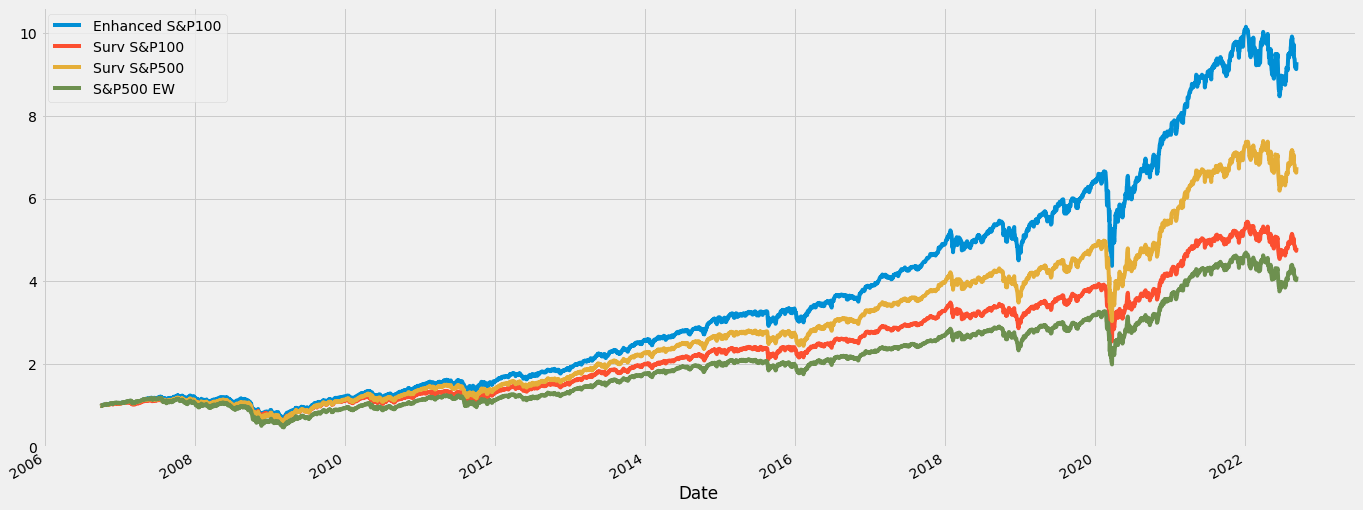

In [193]:
enhanced_sp100_cumreturn.rename("Enhanced S&P100").plot(figsize=(21,9), legend=True)
(1+enhanced_sp100_prices[sp100_survs].pct_change().mean(skipna=True, axis=1)).cumprod().rename("Surv S&P100").plot(legend=True)
(1+sp500_surv_prices.pct_change().mean(skipna=True, axis=1)).cumprod().rename("Surv S&P500").plot(legend=True)
(1+rsp.pct_change()).cumprod().rename("S&P500 EW").plot(legend=True)

## 1.3 **S&P500** Enhancing

We propose supplement _S&P500_ non-survivors with stocks belonging from _Russell 3000_ and surviving all the sample.

### Completing with **Russell 3000**

Catching the stocks needed for completion from **Russell 3000**


In [ ]:
iwv = index_components_finder("IWV") # Online refresh

In [2]:
# Offline refresh
import pandas as pd
iwv = pd.read_pickle("data/pkl/IWV_historical_components_20220908.pkl")
ivv = pd.read_pickle("data/pkl/IVV_historical_components_20220907.pkl")

In [3]:
import time
import re

def change_ticker(ticker):
    rename_table = {
        "-": "LPRAX", # BlackRock LifePath Dynamic Retirement Fund
        "8686": "AFL", # AFLAC
        "4XS": "ESRX", # Express Scripts Holding Company 
        "AAZ": "APC", # Anadarko Petroleum Corporation
        "AG4": "AGN", # Allergan plc
        "BFB": "BF-B", # Brown-Forman Corporation
        "BF.B": "BF-B", # Brown-Forman Corporation
        "BF/B": "BF-B", # Brown-Forman Corporation
        "BF_B" : "BF-B", # Brown-Forman Corporation
        "BLD WI": "BLD", # TopBuild Corp.
        "BRKB": "BRK-B", # Berkshire Hathaway Inc.
        "BRK_B": "BRK-B", # Berkshire Hathaway Inc.
        "CC WI": "CC", # The Chemours Company
        "DC7": "DFS", # Discover Financial Services
        "DWDP": "DD", # Discover Financial Services
        "FB": "META",   # Facebook
        "GGQ7": "GOOG", # Alphabet Inc. Class C
        "GEC": "GE", # General Electric
        "HNZ": "KHC", # The Kraft Heinz Company
        "INCO": "INTC", # Intel
        "LOM": "LMT", # Lockheed Martin Corp.
        "LTD": "LB", # L Brands Inc.
        "LTR": "L", # Loews Corporation        
        "MPN": "MPC", # Marathon Petroleum Corp.
        "MYL": "VTRS", # Mylan NV (VIATRIS)
        "MWZ": "MET", # Metlife Inc.
        "MX4A": "CME", # CME Group Inc.
        "NCRA": "NWSA", # News Corporation
        "NTH": "NOC", # Northrop Grumman Crop.
        "PA9": "TRV", # The Travelers Companies, Inc.
        "QCI": "QCOM", # Qualcomm Inc.
        "RN7": "RF", # Regions Financial Corp
        "RTN" : "RTX", # Raytheon
        "SLBA": "SLB", # Schlumberger Limited
        "SYF-W": "SYF", # Synchrony Financial
        "SWG": "SCHW", # The Charles Schwab Corporation 
        "UAC/C": "UAA", # Under Armour Inc Class A
        "UBSFT": "UBSFY", # Ubisoft Entertainment
        "USX1": "X", # United States Steel Corporation
        "UUM": "UNM", # Unum Group
        "VISA": "V", # Visa Inc         
        "VIAC": "VIA", # viacom
        "WLTW": "WTW" # Willis Towers Watson                
    }
    if ticker in rename_table:
        fix = rename_table[ticker]
    else:
        fix = re.sub(r'[^A-Z]+', '', ticker)
    return fix

In [4]:
def surviving_stocks(data):
    """Parse (and correct with change_ticker()) stock component and find out all-times surviving stocks
    """
    initial_constituents = [change_ticker(sym[0]) for sym in data[0]]
    final_constituents = [change_ticker(sym[0]) for sym in data[-1]]
    return set(initial_constituents).intersection(set(final_constituents))

In [5]:
rl3000_survivors = surviving_stocks(iwv)
sp500_survivors = surviving_stocks(ivv)
print(f"Russell 3000 Surviving Stocks #: {len(rl3000_survivors)}")
print(f"S&P500 Surviving Stocks #: {len(sp500_survivors)}")

Russell 3000 Surviving Stocks #: 1154
S&P500 Surviving Stocks #: 248


1. 912 candidates from Russell 3000 for completing the S&P500 surviving stocks

In [6]:
sp500_supplementary = rl3000_survivors.difference(sp500_survivors)
len(sp500_supplementary)

909

In [7]:
sp500_supplementary.intersection(sp500_survivors)

set()

In [8]:
ivv.index[0].strftime("%Y-%m-%d"), ivv.index[-1].strftime("%Y-%m-%d")

('2006-09-29', '2022-09-07')

In [17]:
# Frequent Downloading Errors (YFinance API). Need to be Handled (by chunking the list of candidate tickers or retrying)
import yfinance as yf

""" def chunks(lst, n):
    Yield successive n-sized chunks from lst.
    for i in range(0, len(lst), n):
        yield lst[i:i + n] 
"""

lst_rl3000_candidates = []
chunksize = 100

for i in range(0, len(sp500_supplementary), chunksize):

    px = yf.download(
        tickers=list(sp500_supplementary)[i:i+chunksize],
        start = ivv.index[0],
        end=ivv.index[-1],    
        show_errors=True
    )["Adj Close"]

    lst_rl3000_candidates.append(px)

sp500_supplementary_prices = pd.concat(lst_rl3000_candidates, axis=1, join="inner")

[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed

1 Failed download:
- MOGA: No data found, symbol may be delisted
[*********************100%***********************]  100 of 100 completed

1 Failed download:
- GTXI: No data found, symbol may be delisted
[*********************100%***********************]  100 of 100 completed

1 Failed download:
- ARD: No data found, symbol may be delisted
[*********************100%***********************]  100 of 100 completed

1 Failed download:
- PN: No data found for this date range, symbol may be delisted
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  9 of 9 com

In [18]:
sp500_supplementary_prices.head()

,ABMD,AGYS,ALK,AMKR,ANET,ARRY,ARW,ASH,ATNI,AVA,...,WTS,CMCO,CWH,FORR,FRT,LHCG,OHI,TBBK,TDG,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2006-09-28 00:00:00,15.09,13.869942,8.648644,5.397821,NaN,NaN,27.020000,25.019012,14.140655,12.835989,...,26.587381,17.524000,NaN,21.796356,44.546612,21.879999,4.699045,26.120001,10.538547,31.957037
2006-09-29 00:00:00,14.78,13.484666,8.551974,5.063530,NaN,NaN,27.430000,24.712912,13.863097,12.707201,...,26.363264,17.051149,NaN,21.176586,44.207462,22.320000,4.699045,25.490000,10.377069,31.588058
2006-10-02 00:00:00,14.73,13.330557,8.776790,5.073362,NaN,NaN,27.200001,24.771023,13.855597,12.734032,...,25.848614,16.824175,NaN,21.804401,43.713627,22.730000,4.699045,26.010000,10.066863,31.212835
2006-10-03 00:00:00,14.44,13.552090,9.179211,5.211012,NaN,NaN,27.400000,24.519171,13.915608,12.766221,...,26.014633,16.890377,NaN,21.957333,44.165813,22.910000,4.699045,26.049999,10.037116,31.050226
2006-10-04 00:00:00,14.95,13.821782,9.424260,5.456814,NaN,NaN,27.570000,24.720654,14.200668,13.034538,...,26.645494,17.325401,NaN,22.609297,44.820309,23.500000,4.792964,26.830000,10.198595,31.281628


In [19]:
sp500_supplementary_prices.to_csv(
    "data/config/20220907_rl3000surv_price_components_initial_data.csv",
    index_label="Date",
    index=True,
    na_rep="#N/A"
)

2. Dropping stocks with Null Values

In [20]:
# Dropping Stocks With Missing Quotes
rl3000_stocks_nulldata = list(sp500_supplementary_prices.isna().sum()[sp500_supplementary_prices.isna().sum()!=0].index)
len(rl3000_stocks_nulldata)

79

In [21]:
sp500_supplementary_prices.drop(columns=rl3000_stocks_nulldata, inplace=True)
sp500_supplementary_prices.isna().sum().sum()

0

In [22]:
sp500_supplementary_prices.to_csv(
    "data/config/20220907_rl3000surv_price_components_non-null_data.csv",
    index_label="Date",
    index=True,    
)

3. Finding out Stocks with Quotes Below 1$ treshold, and dropping

In [23]:
one_buck_below_quotes = (sp500_supplementary_prices[sp500_supplementary_prices<1].notna().sum()!=0)
one_buck_below_quotes = list(sp500_supplementary_prices.columns[one_buck_below_quotes])

In [24]:
len(one_buck_below_quotes)

62

In [25]:
sp500_supplementary_prices.drop(columns=one_buck_below_quotes, inplace=True)
sp500_supplementary_prices.isna().sum().sum()

0

In [26]:
len(sp500_supplementary_prices.columns)

768

In [27]:
sp500_supplementary_prices.to_csv(
    "data/config/20220907_rl3000surv_price_components_non-null_filtered_data.csv",
    index_label="Date",
    index=True,    
)

### **SP500** Surviving Assets

Let us find out now _the daily closes of the components belonging to the S&P500_ over the sample period under consideration

In [28]:
sp500_surviving_prices = yf.download(
    tickers=list(sp500_survivors),
    start = ivv.index[0],
    end=ivv.index[-1],    
    show_errors=True
)["Adj Close"]

[*********************100%***********************]  248 of 248 completed


In [29]:
sp500_surviving_prices.columns[sp500_surviving_prices.isna().sum()!=0]

Index(['CEG', 'DG', 'DOW', 'HCA', 'HLT', 'IR', 'KHC', 'KMI', 'NWSA'], dtype='object')

In [30]:
sp500_stocks_nulldata = list(sp500_surviving_prices.columns[sp500_surviving_prices.isna().sum()!=0])
sp500_surviving_prices.drop(columns=sp500_stocks_nulldata, inplace=True)

In [31]:
len(sp500_surviving_prices.columns)

239

In [32]:
sp500_surviving_prices.isna().sum().sum()

0

In [34]:
sp500_surviving_prices.to_csv(
    "data/config/20220907_sp500surv_price_components_non-null_data.csv",
    index_label="Date",
    index=True,    
)

[*********************100%***********************]  1 of 1 completed


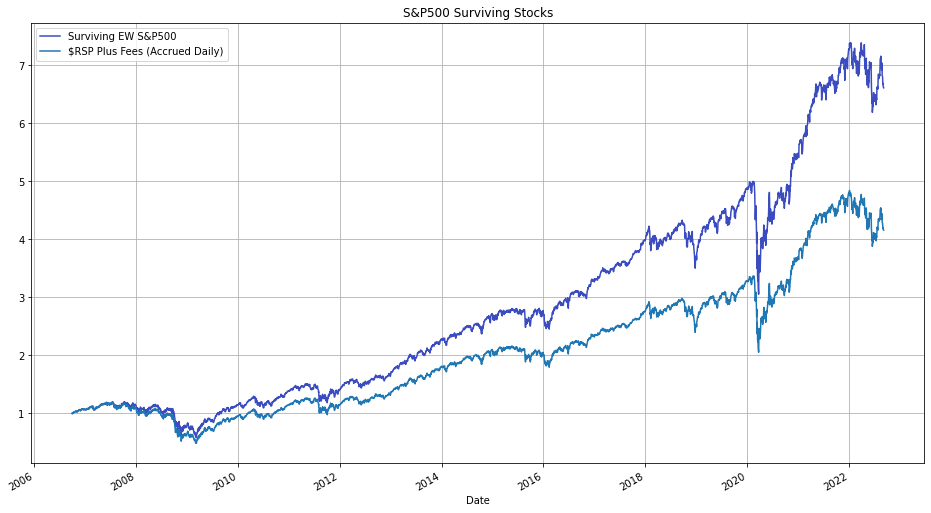

In [35]:
import matplotlib.pyplot as plt

(1+sp500_surviving_prices.pct_change().mean(axis=1)).cumprod().rename("Surviving EW S&P500").plot(
    figsize=(16,9),
    legend=True,
    cmap="coolwarm",
    title="S&P500 Surviving Stocks"
)

rsp_prices = yf.download(
    tickers="RSP",
    start=ivv.index[0],
    end=ivv.index[-1]
)["Adj Close"]

(1+rsp_prices.pct_change()+0.002/252).cumprod().rename("$RSP Plus Fees (Accrued Daily)").plot(
    legend=True
)

plt.grid();

Computing Total Return at the end of the Sample Period

In [36]:
from modules import performance_measures_helper as pms

sp500_surviving_total_rets = pms.net_cumreturn(
    sp500_surviving_prices.pct_change(),
    last_row=True
)

sp500_surviving_total_rets.sort_values(ascending=False)

AMZN    78.214824
AAPL    64.803841
NVDA    28.753691
AZO     19.451675
SHW     14.104981
          ...    
VNO     -0.359269
VTRS    -0.502993
GE      -0.587313
CCL     -0.705286
AIG     -0.939829
Name: 2022-09-06 00:00:00, Length: 239, dtype: float64

In [37]:
# Stablishing a treshold for completing SP500 surviving stocks
q10 = sp500_surviving_prices.pct_change().mean().quantile(.1) # First Decile
q20 = sp500_surviving_prices.pct_change().mean().quantile(.2) # First Quintile
q25 = sp500_surviving_prices.pct_change().mean().quantile(.25) # First Quartile
q33 = sp500_surviving_prices.pct_change().mean().quantile(.33) # First Tercile
q0 = sp500_surviving_prices.pct_change().mean().min() # Min
q100 = sp500_surviving_prices.pct_change().mean().max() # Max

header = "Quantiles of the Distribution of Sample Mean for SP500 Surviving Stocks"

print(header)
print(len(header)*"=")
print(f"Min: {100*252*q0:.2f}%")
print(f"First Decile: {100*252*q10:.2f}%")
print(f"First Quintile: {100*252*q20:.2f}%")
print(f"First Quartile: {100*252*q25:.2f}%")
print(f"First Quartile: {100*252*q33:.2f}%")
print(f"Max: {100*252*q100:.2f}%")


Quantiles of the Distribution of Sample Mean for SP500 Surviving Stocks
Min: 0.57%
First Decile: 9.04%
First Quintile: 10.42%
First Quartile: 11.24%
First Quartile: 12.17%
Max: 34.75%


In [38]:
sp500_surviving_prices.columns[sp500_surviving_prices.pct_change().mean()<q25]

Index(['AEE', 'AES', 'AIG', 'BAX', 'BEN', 'BK', 'BXP', 'CAG', 'CAH', 'CCL',
       'CL', 'CLX', 'CPB', 'CSCO', 'D', 'DD', 'DGX', 'DUK', 'ED', 'EIX', 'ETR',
       'EXC', 'FDX', 'FE', 'GE', 'GLW', 'IBM', 'INTC', 'JCI', 'JNJ', 'JNPR',
       'K', 'KEY', 'KIM', 'KMB', 'KO', 'L', 'LH', 'LUMN', 'MDT', 'MMM', 'NEM',
       'NWL', 'OMC', 'PEP', 'PFE', 'PG', 'PNW', 'PPL', 'SLB', 'T', 'TAP',
       'TFC', 'USB', 'VNO', 'VTRS', 'VZ', 'WMT', 'XOM', 'ZBH'],
      dtype='object')

In [39]:
# The RL3000 All Times (Filtered) Surviving Stocks
qq10 = sp500_supplementary_prices.pct_change().mean().quantile(.1) # First Decile
qq20 = sp500_supplementary_prices.pct_change().mean().quantile(.2) # First Quintile
qq25 = sp500_supplementary_prices.pct_change().mean().quantile(.25) # First Quartile
qq33 = sp500_supplementary_prices.pct_change().mean().quantile(.33) # First Tercile
qq0 = sp500_supplementary_prices.pct_change().mean().min() # Min
qq100 = sp500_supplementary_prices.pct_change().mean().max() # Max

header = "Quantiles of the Distribution of Sample Mean for SP500 Supplmentary Stocks (RL3000)"

print(header)
print(len(header)*"=")
print(f"Min: {100*252*qq0:.2f}%")
print(f"First Decile: {100*252*qq10:.2f}%")
print(f"First Quintile: {100*252*qq20:.2f}%")
print(f"First Quartile: {100*252*qq25:.2f}%")
print(f"First Tercile: {100*252*qq33:.2f}%")
print(f"Max: {100*252*qq100:.2f}%")

Quantiles of the Distribution of Sample Mean for SP500 Supplmentary Stocks (RL3000)
Min: -6.13%
First Decile: 8.35%
First Quintile: 10.85%
First Quartile: 11.52%
First Tercile: 12.66%
Max: 45.74%


In [40]:
len(sp500_supplementary_prices.columns)

768

In [85]:
# By adding these 286 stocks we complete the index with a total of 507 components over all the sample period 
# without missing data
sp500_added_stocks = list(sp500_supplementary_prices.columns[sp500_supplementary_prices.pct_change().mean()<q33])

In [86]:
sp500_supplementary_prices[sp500_added_stocks].isna().sum().sum()

0

In [87]:
len(sp500_supplementary_prices[sp500_added_stocks].columns)

230

<AxesSubplot:title={'center':'Agg (Equally-Weighted) Behaviour of RL3000'}, xlabel='Date'>

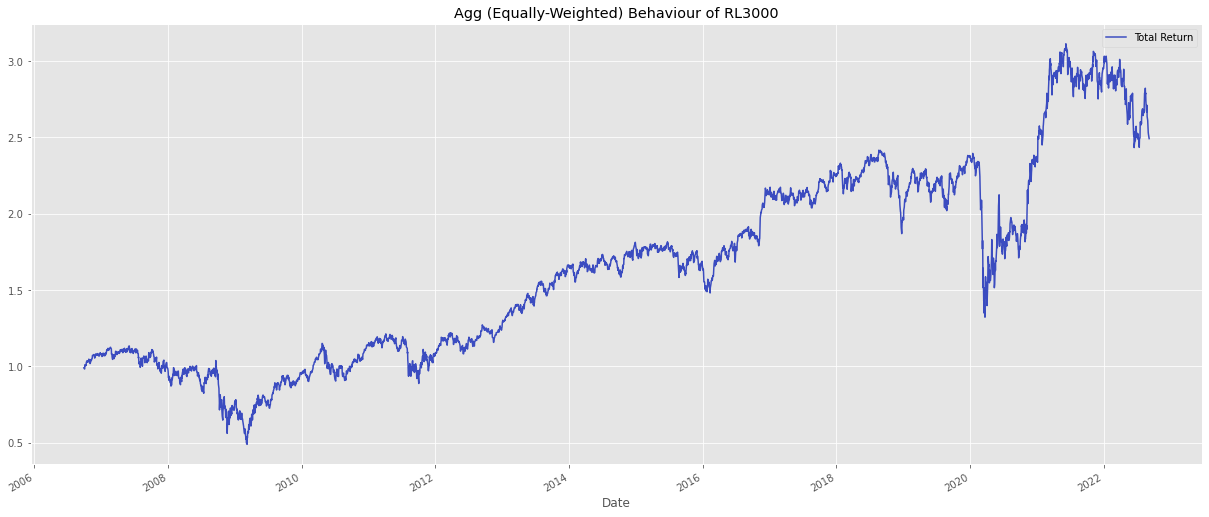

In [88]:
(1+sp500_supplementary_prices[sp500_added_stocks].pct_change().mean(axis=1)).cumprod().rename("Total Return").plot(
    figsize=(21,9),
    title="Agg (Equally-Weighted) Behaviour of RL3000",
    legend=True,
    cmap="coolwarm"
)


In [45]:
sp500_supplementary_prices[sp500_added_stocks]

,AVA,BBBY,CAKE,CIR,FBC,FCBC,HAFC,HE,HLX,HSII,...,NWN,PRGO,RGP,SBCF,SHBI,UGI,WAFD,FORR,FRT,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2006-09-28,12.835989,33.829247,23.155605,29.618546,1390.411011,20.159607,115.742622,13.386889,33.310001,25.853233,...,22.555159,14.726097,18.587454,142.012787,21.780539,10.325500,15.254732,21.796356,44.546612,31.957037
2006-09-29,12.707201,33.358433,22.927923,29.283062,1367.848755,19.856140,115.038300,13.288680,33.400002,25.422464,...,22.249292,14.631257,18.429232,135.378357,21.444868,10.187994,15.173594,21.176586,44.207462,31.588058
2006-10-02,12.734032,33.628712,22.405113,28.612095,1359.387329,18.939793,112.162384,13.362338,31.309999,25.147045,...,22.232300,14.553657,18.690634,129.909439,20.795927,10.192159,15.153305,21.804401,43.713627,31.212835
2006-10-03,12.766221,34.422134,22.430408,28.861317,1345.285889,18.999302,113.277542,13.381983,29.160000,25.422464,...,22.300268,14.795074,18.938282,127.309456,20.661669,10.204659,15.031600,21.957333,44.165813,31.050226
2006-10-04,13.034538,35.049896,23.492899,30.634594,1368.788452,19.987041,116.564377,13.475289,28.530001,26.163950,...,22.719433,14.907149,19.412949,128.071518,21.288231,10.212996,15.253399,22.609297,44.820309,31.281628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30,41.290001,12.110000,30.520000,16.680000,38.849998,32.009998,24.950001,39.520000,4.370000,28.840000,...,48.130001,37.676384,19.870001,32.623150,19.270000,39.141705,32.700001,41.259998,102.720001,56.330002
2022-08-31,40.630001,9.530000,30.620001,16.299999,38.529999,31.530001,24.719999,39.119999,4.320000,28.459999,...,47.610001,37.159996,19.540001,32.145741,19.049999,39.131798,32.009998,41.590000,101.269997,55.950001
2022-09-01,41.259998,8.710000,31.049999,15.910000,38.279999,31.490000,24.350000,39.500000,4.160000,28.379999,...,47.669998,36.779999,19.639999,32.215363,18.889999,38.715714,31.830000,41.009998,101.290001,55.540001


**Finally** we join the two Surviving Sets as the Initial Dataset

In [47]:
sp500m_prices = pd.concat([sp500_surviving_prices, sp500_supplementary_prices[sp500_added_stocks]], axis=1)

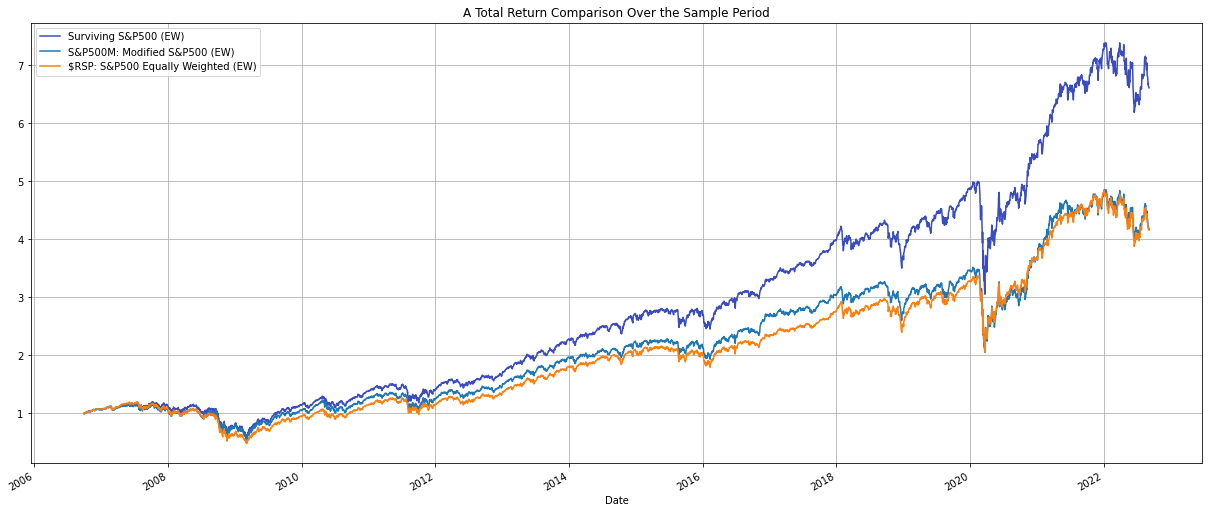

In [48]:
(1+sp500_surviving_prices.pct_change().mean(axis=1)).rename("Surviving S&P500 (EW)").cumprod().plot(
    figsize=(21,9), 
    title="A Total Return Comparison Over the Sample Period",
    legend=True,
    cmap="coolwarm")
(1+sp500m_prices.pct_change().mean(axis=1)).rename("S&P500M: Modified S&P500 (EW)").cumprod().plot(legend=True)
(1+rsp_prices.pct_change()+0.002/252).rename("$RSP: S&P500 Equally Weighted (EW)").cumprod().plot(legend=True)

plt.grid();

In [49]:
sp500m_prices.columns

Index(['A', 'AAPL', 'ABC', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE',
       ...
       'NWN', 'PRGO', 'RGP', 'SBCF', 'SHBI', 'UGI', 'WAFD', 'FORR', 'FRT',
       'WABC'],
      dtype='object', length=469)

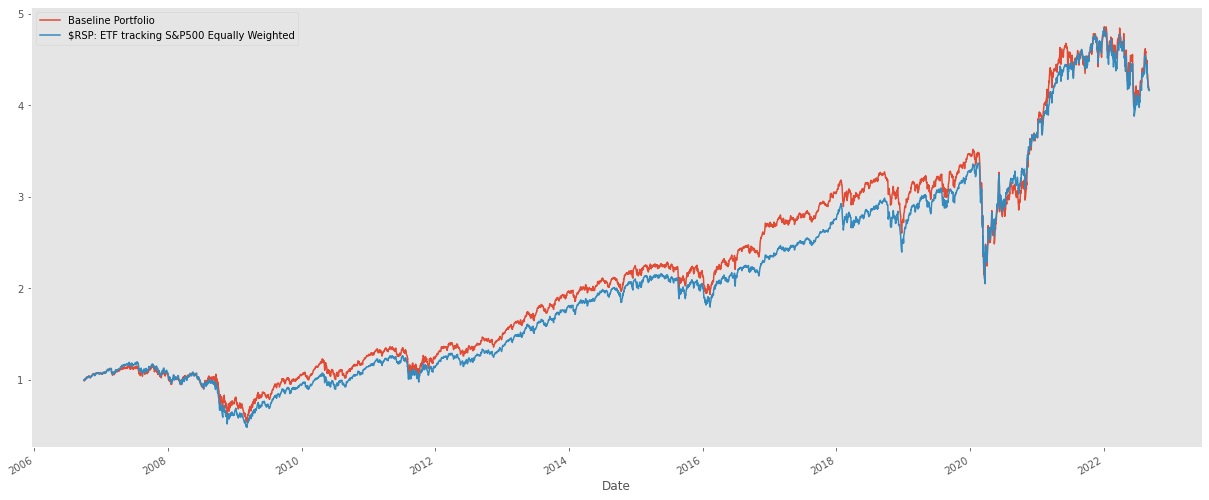

In [54]:
plt.style.use("ggplot")

(1+sp500m_prices.pct_change().mean(axis=1)).rename("Baseline Portfolio").cumprod().plot(
    figsize=(21,9), 
    legend=True)

(1+rsp_prices.pct_change()+0.002/252).rename("$RSP: ETF tracking S&P500 Equally Weighted").cumprod().plot(legend=True)
plt.grid()

In [51]:
delta = ivv.index[-1] - ivv.index[0]
delta.to_pytimedelta()

datetime.timedelta(days=5822)

In [52]:
years_since_inception = delta.to_pytimedelta().days/365.25

In [55]:
pms.net_cumreturn(sp500m_prices.pct_change().mean(axis=1), last_row=True)**(1/years_since_inception)-1

0.07508793484012743

In [57]:
pms.net_cumreturn(rsp_prices.pct_change(), last_row=True)**(1/years_since_inception)-1

0.0719830168750013

In [58]:
sp500m_prices.pct_change().mean(axis=1).mean()*252

0.11687168484182861

In [59]:
rsp_prices.pct_change().mean()*252

0.11157334254540507

In [60]:
sp500m_prices.tail()

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,NWN,PRGO,RGP,SBCF,SHBI,UGI,WAFD,FORR,FRT,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-30 00:00:00,128.279999,158.910004,145.429993,102.199997,375.070007,152.729996,87.570000,244.533340,202.809998,92.747398,...,48.130001,37.676384,19.870001,32.623150,19.270000,39.141705,32.700001,41.259998,102.720001,56.330002
2022-08-31 00:00:00,128.250000,157.220001,146.559998,102.650002,373.440002,151.529999,87.889999,243.358429,201.740005,92.031975,...,47.610001,37.159996,19.540001,32.145741,19.049999,39.131798,32.009998,41.590000,101.269997,55.950001
2022-09-01 00:00:00,128.929993,157.960007,147.610001,104.839996,370.529999,150.690002,87.580002,244.901764,201.949997,93.264099,...,47.669998,36.779999,19.639999,32.215363,18.889999,38.715714,31.830000,41.009998,101.290001,55.540001
2022-09-02 00:00:00,128.009995,155.809998,147.710007,102.500000,368.140015,148.630005,87.610001,237.453934,198.690002,92.340004,...,47.490002,36.740002,19.389999,32.105953,18.690001,38.676086,31.530001,39.799999,100.769997,55.490002
2022-09-06 00:00:00,129.300003,154.529999,146.020004,102.709999,368.299988,148.229996,85.699997,237.115402,198.179993,92.220001,...,48.290001,37.950001,19.530001,31.280432,18.450001,38.210468,30.889999,40.139999,103.190002,54.689999


* Dumping all price components data for future use

In [102]:
sp500m_prices.to_csv(
    "data/config/20220907_baseline_price_components_data.csv",
    index_label="Date",
    index=True
)

* Checking

In [103]:
sp500 = pd.read_csv(
    "data/config/20220907_baseline_price_components_data.csv",
    index_col="Date",
    parse_dates=True
)

In [104]:
sp500.shape

(4012, 469)

* Stocks with prices below 1$ at any busi

In [65]:
list(sp500.columns[(sp500[sp500<1].sum()!=0)])

['F', 'FITB', 'HBAN']

* Checking if Missing Data

In [361]:
sp500.isna().sum().sum()

0

### A1 Annex: Metrics Comparison between SP500-Mod EW and RSP ETF (Actual SP500 EW Replica)

**NOTA** Defender la cartera baseline (`SP500M`) como buen baseline similar a indice (sin problemas de sesgo de supervivencia), en base a métricas a 10, 5, 3 (returns y sharpes a plazo)

In [68]:
total_rets_10Y = sp500.pct_change().rolling(window="3600D", min_periods=2400).apply(pms.multi_period_return)

<AxesSubplot:xlabel='Date'>

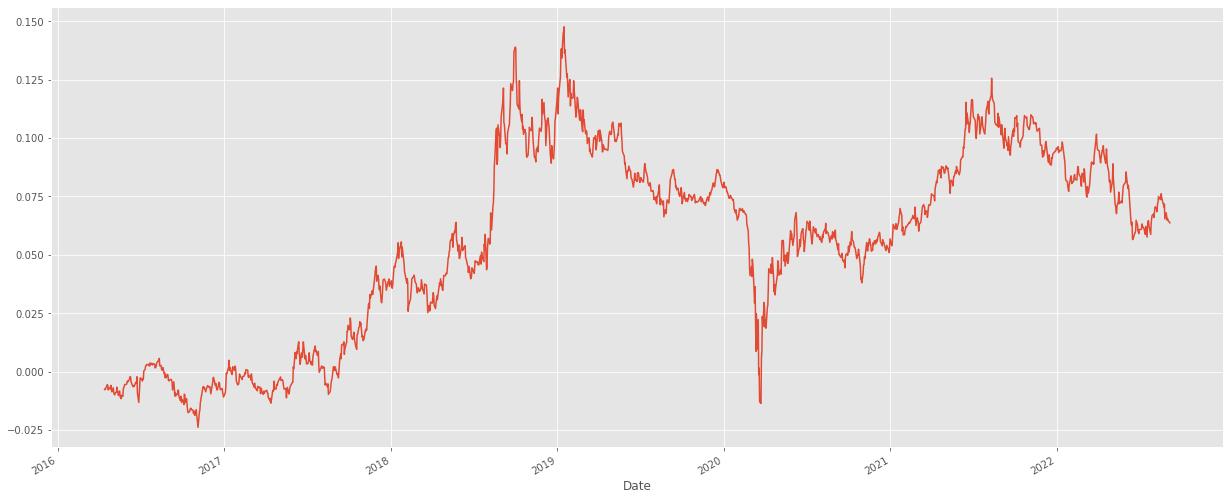

In [70]:
(total_rets_10Y.mean(axis=1)**(1/10)-1).plot(figsize=(21,9))

In [72]:
total_rets_10Y.mean(axis=1)[-1]

1.8540497333788408

In [73]:
rsp_10y_returns = rsp_prices.pct_change().rolling(window="3600D", min_periods=2400).apply(pms.multi_period_return)

In [74]:
rsp_10y_returns[-1]

2.1753163203102517

* ***Translate*** to year equivalents (an excerpt from the [_Vanguard_](https://investor.vanguard.com/investment-products/etfs/profile/vthr#performance-fees) webpage):

![Returns over distinct Horizons for EW SP500-M and $RSP](./pics/returns_dashboard_template.png)

### A2 Annex: Compiling Baseline Portfolio Use

In [77]:
len(sp500_surviving_prices.columns)

239

In [89]:
# Compiling Tickers Information for Further Use
rl3000_tickers_added = pd.DataFrame(
    {
        "ticker": sp500_added_stocks,
        "index": ["^RUA"]*len(sp500_added_stocks)
    }
)

In [91]:
rl3000_tickers_added

,ticker,index
0,AVA,^RUA
1,BBBY,^RUA
2,CAKE,^RUA
3,CIR,^RUA
4,FBC,^RUA
...,...,...
225,UGI,^RUA
226,WAFD,^RUA
227,FORR,^RUA
228,FRT,^RUA


In [93]:
sp500_surviving_prices.columns

Index(['A', 'AAPL', 'ABC', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE',
       ...
       'WHR', 'WM', 'WMB', 'WMT', 'WY', 'XEL', 'XOM', 'YUM', 'ZBH', 'ZION'],
      dtype='object', length=239)

In [95]:
sp500_tickers_surv = pd.DataFrame(
    {
        "ticker": list(sp500_surviving_prices.columns),
        "index": ["^GSPC"]*len(sp500_surviving_prices.columns)
    }
)
sp500_tickers_surv

,ticker,index
0,A,^GSPC
1,AAPL,^GSPC
2,ABC,^GSPC
3,ABT,^GSPC
4,ADBE,^GSPC
...,...,...
234,XEL,^GSPC
235,XOM,^GSPC
236,YUM,^GSPC
237,ZBH,^GSPC


In [100]:
sp500m_tickers = pd.concat(
    [rl3000_tickers_added, sp500_tickers_surv],
    axis=0
)
sp500m_tickers

,ticker,index
0,AVA,^RUA
1,BBBY,^RUA
2,CAKE,^RUA
3,CIR,^RUA
4,FBC,^RUA
...,...,...
234,XEL,^GSPC
235,XOM,^GSPC
236,YUM,^GSPC
237,ZBH,^GSPC


In [101]:
sp500m_tickers.to_csv(
    "data/config/baseline_constituents.csv",
    index=False
)